# Spam Message Classification using Logistic Regression and Neural Networks

## Data Loading

In [147]:
import pandas as pd

data = pd.read_csv("Phishing_Email.csv")
data.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [148]:
data.columns = ["id", "text", "label"]
data = data.drop(columns=["id"])

print(data.value_counts(subset="label"))
data["label"] = data["label"].apply(lambda x: 0 if x=="Safe Email" else 1)  # label encoding

label
Safe Email        11322
Phishing Email     7328
Name: count, dtype: int64


In [149]:
data.isnull().sum()

text     16
label     0
dtype: int64

In [150]:
data = data.dropna()  # Just drop null and missing values 

data = data[data["text"] != "empty"]  # Many rows in the data contain the string "empty"; remove

## Preprocessing + Visualization

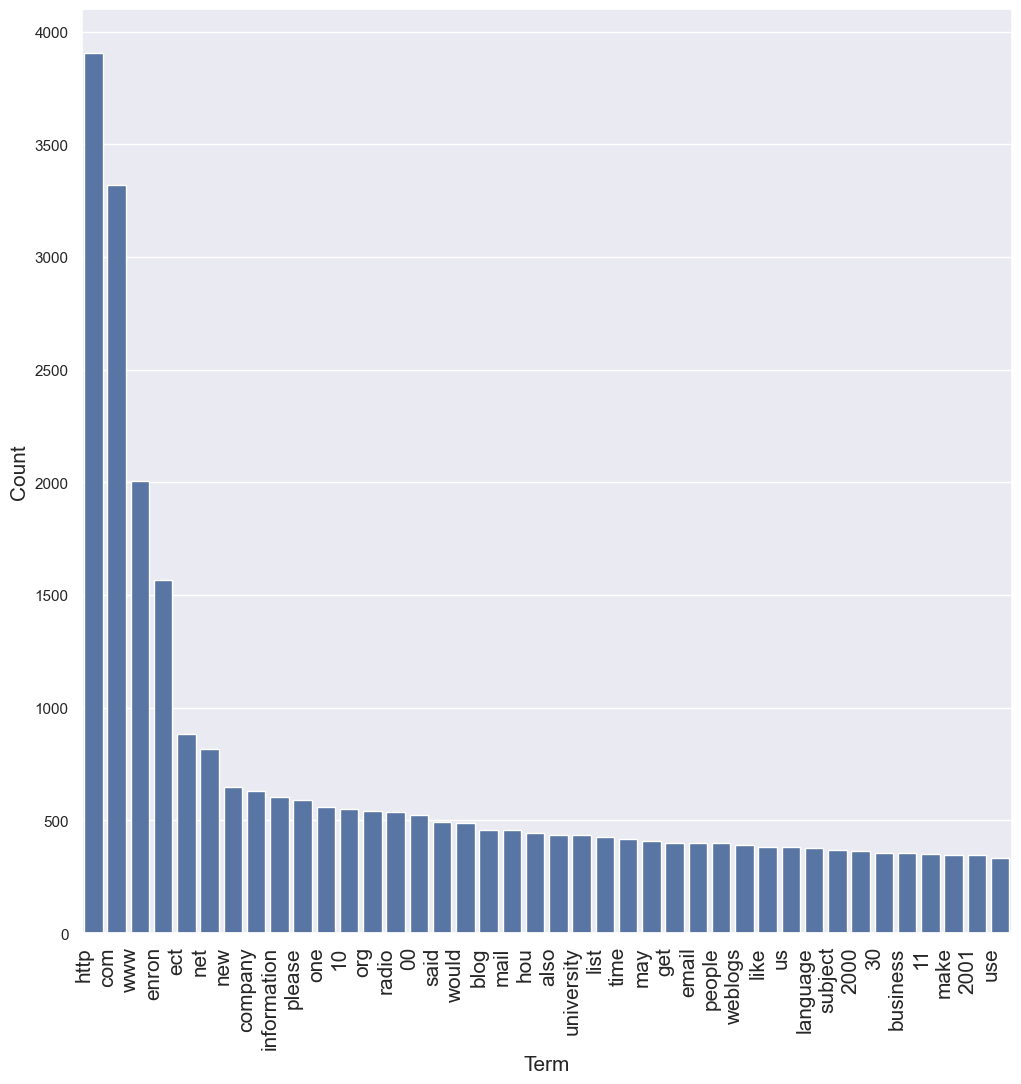

In [151]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import copy
from nltk.corpus import stopwords

sns.set_theme(rc={"figure.figsize":(12,12)})

stopwords = list(stopwords.words("english"))

visualization_subset = data.sample(n=1000)
cv = CountVectorizer(stop_words=stopwords)
term_counts = cv.fit_transform(visualization_subset["text"]).toarray()
counts = np.sum(term_counts, axis=0)
counts_temp = copy.deepcopy(counts)
counts_temp = np.sort(counts_temp)[::-1]
counts_top40 = counts_temp[:40][-1]  # count threshold for term to be in top 40 terms

feature_counts = {}
for term, idx in cv.vocabulary_.items():
    feature_counts.update({term:counts[idx]})

feature_counts = {term:count for term, count in feature_counts.items() if count >= counts_top40}
feature_counts = pd.Series(feature_counts.values(), index=feature_counts.keys()).sort_values(ascending=False)
plot = sns.barplot(data=feature_counts)
del term_counts
plot.set_xlabel("Term", fontsize=15)
plot.set_ylabel("Count", fontsize=15)
plt.xticks(rotation=90, ha="right", fontsize=15)
plt.show()

In [152]:
stopwords.extend(["http", "com", "org", "www", "enron", "ect", feature_counts.index[0]])  # add junk values to stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words=stopwords, max_features=1000)
example_text = data["text"].iloc[0]
text_enc = tfidf.fit_transform(data["text"]).toarray()

idx = 0
def add_text_encodings(text):
    global idx
    enc = text_enc[idx]
    idx += 1
    return enc
data["text"] = data["text"].apply(add_text_encodings)
print(example_text)
print("\n\n\nBecomes:\n\n\n")
print(data["text"].iloc[0])

re : 6 . 1100 , disc : uniformitarianism , re : 1086 ; sex / lang dick hudson 's observations on us use of 's on ' but not 'd aughter ' as a vocative are very thought-provoking , but i am not sure that it is fair to attribute this to " sons " being " treated like senior relatives " . for one thing , we do n't normally use ' brother ' in this way any more than we do 'd aughter ' , and it is hard to imagine a natural class comprising senior relatives and 's on ' but excluding ' brother ' . for another , there seem to me to be differences here . if i am not imagining a distinction that is not there , it seems to me that the senior relative terms are used in a wider variety of contexts , e . g . , calling out from a distance to get someone 's attention , and hence at the beginning of an utterance , whereas 's on ' seems more natural in utterances like ' yes , son ' , ' hand me that , son ' than in ones like ' son ! ' or ' son , help me ! ' ( although perhaps these latter ones are not compl

## Visualization

<Axes: xlabel='x', ylabel='y'>

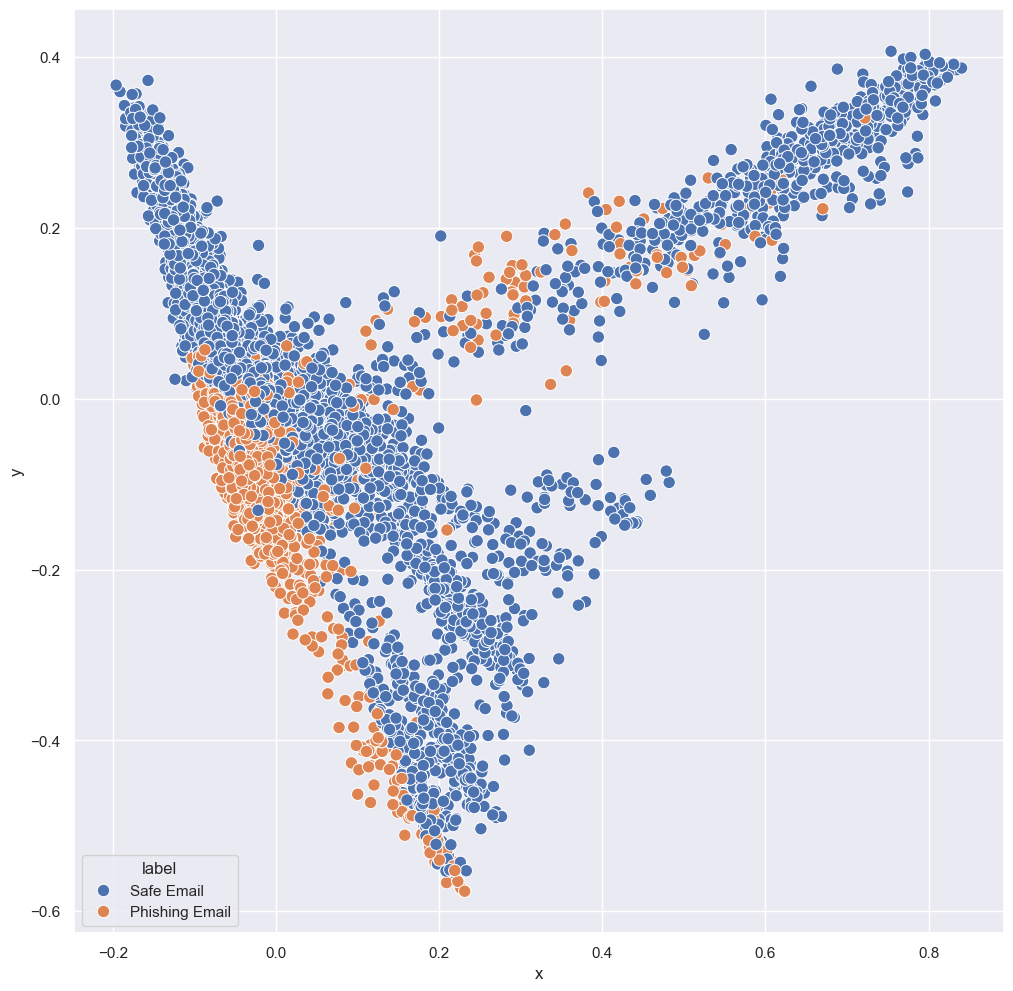

In [153]:
from sklearn.decomposition import PCA

data_pca = data.copy()
pca = PCA(n_components=2)
pca_features = pca.fit_transform(data_pca["text"].to_numpy().tolist())
x = [feat[0] for feat in pca_features]
y = [feat[1] for feat in pca_features]
data_pca["label"] = data_pca["label"].apply(lambda x: "Safe Email" if x==0 else "Phishing Email")
data_pca = data_pca.drop(columns=["text"])
data_pca["x"] = x
data_pca["y"] = y
sns.scatterplot(data=data_pca, x="x", y="y", hue="label", s=80)

## Modeling

## Logistic Regression, L1/L2 Regularization

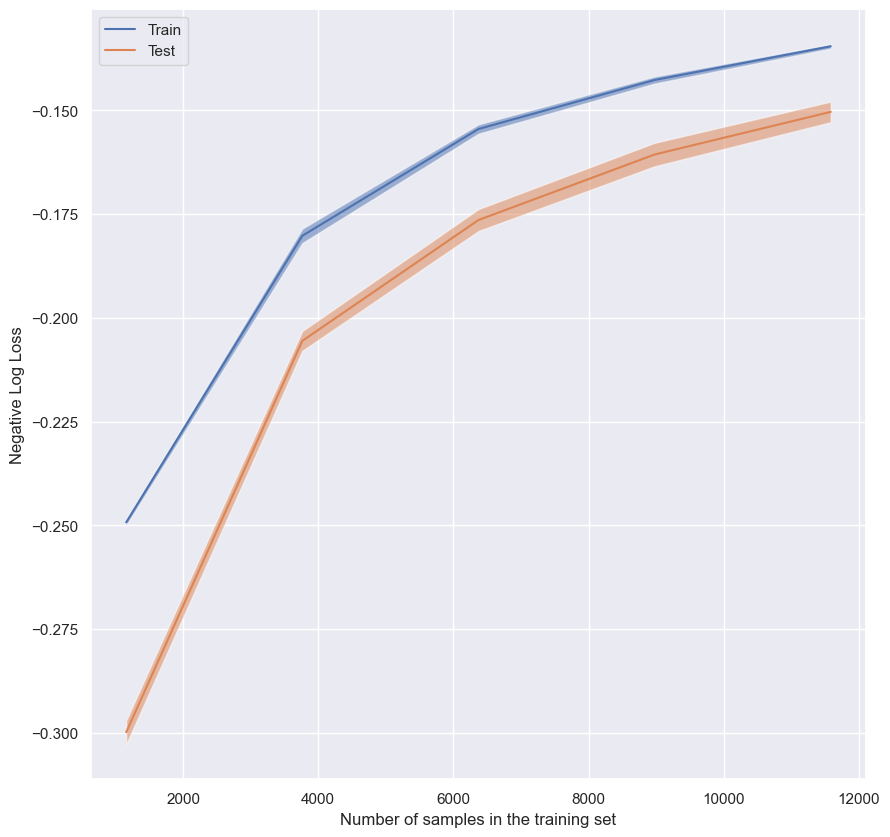

In [154]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve, LearningCurveDisplay
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

sns.set_theme(rc={"figure.figsize":(10,10)})

X = data["text"].to_numpy()
y = data["label"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X.tolist(), y.tolist(), test_size=0.2)

lr = LogisticRegression(penalty="l2", solver="saga")
train_sizes, train_scores, test_scores = learning_curve(lr, X_train, y_train, scoring="neg_log_loss")
disp = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="Negative Log Loss")
disp.plot()

In [155]:
lr.fit(X_train, y_train)
ytst_hat = lr.predict(X_test)

classification_report(y_test, ytst_hat, labels=[0, 1], target_names=["Safe Email", "Phishing Email"], output_dict=True)

{'Safe Email': {'precision': 0.9574759945130316,
  'recall': 0.9672055427251732,
  'f1-score': 0.9623161764705882,
  'support': 2165.0},
 'Phishing Email': {'precision': 0.9504881450488145,
  'recall': 0.9361263736263736,
  'f1-score': 0.9432525951557094,
  'support': 1456.0},
 'accuracy': 0.9547086440209887,
 'macro avg': {'precision': 0.953982069780923,
  'recall': 0.9516659581757734,
  'f1-score': 0.9527843858131488,
  'support': 3621.0},
 'weighted avg': {'precision': 0.9546661881556993,
  'recall': 0.9547086440209887,
  'f1-score': 0.9546507320092616,
  'support': 3621.0}}

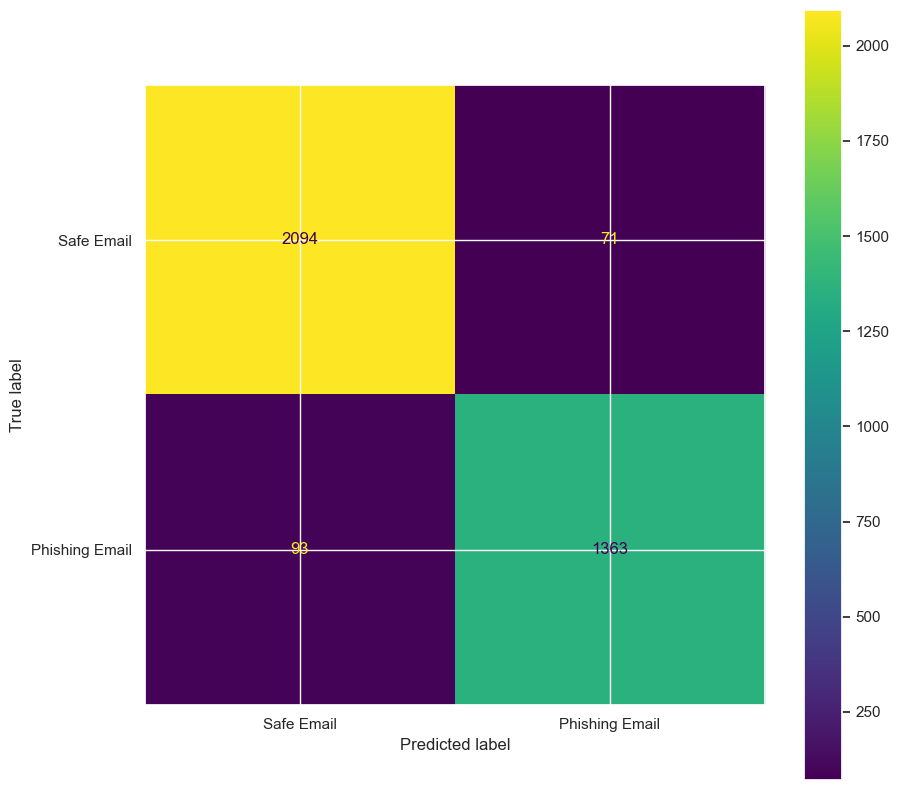

In [156]:
cm = confusion_matrix(y_test, ytst_hat)
cmplot = ConfusionMatrixDisplay(cm, display_labels=["Safe Email", "Phishing Email"])
cmplot.plot()

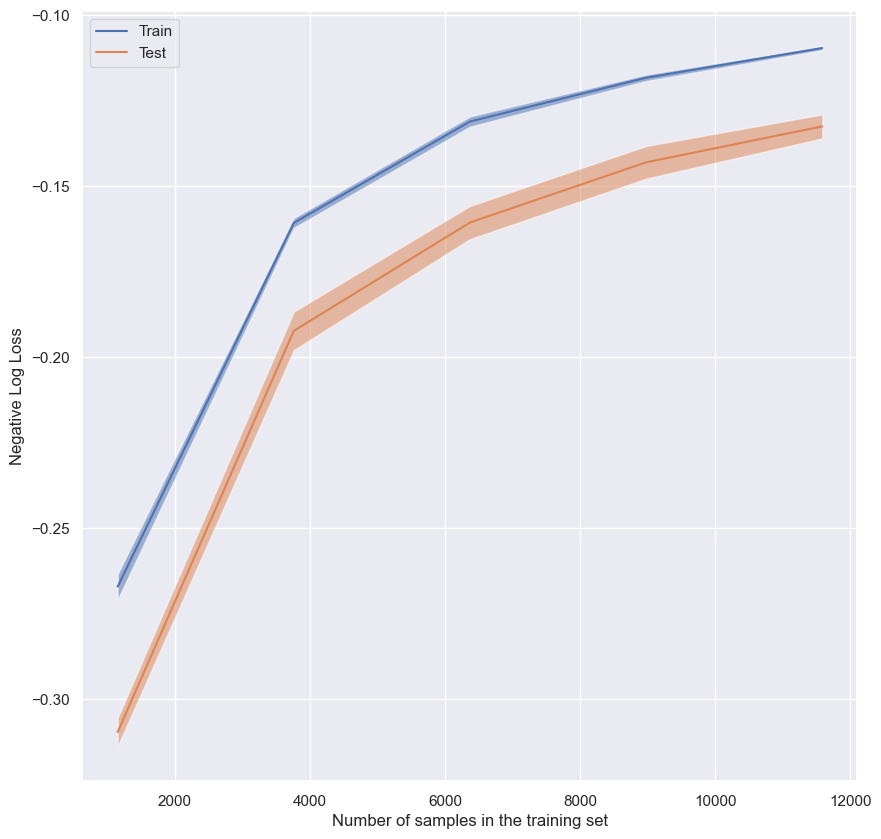

In [157]:
lr = LogisticRegression(penalty="l1", solver="saga", max_iter=500)
train_sizes, train_scores, test_scores = learning_curve(lr, X_train, y_train, scoring="neg_log_loss")
disp = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="Negative Log Loss")
disp.plot()

In [158]:
lr.fit(X_train, y_train)
ytrn_hat = lr.predict(X_train)
ytst_hat = lr.predict(X_test)

classification_report(y_test, ytst_hat, labels=[0, 1], target_names=["Safe Email", "Phishing Email"], output_dict=True)

{'Safe Email': {'precision': 0.9611650485436893,
  'recall': 0.9602771362586605,
  'f1-score': 0.960720887245841,
  'support': 2165.0},
 'Phishing Email': {'precision': 0.9410150891632373,
  'recall': 0.9423076923076923,
  'f1-score': 0.9416609471516816,
  'support': 1456.0},
 'accuracy': 0.9530516431924883,
 'macro avg': {'precision': 0.9510900688534634,
  'recall': 0.9512924142831765,
  'f1-score': 0.9511909171987614,
  'support': 3621.0},
 'weighted avg': {'precision': 0.9530627726922841,
  'recall': 0.9530516431924883,
  'f1-score': 0.9530569069152427,
  'support': 3621.0}}

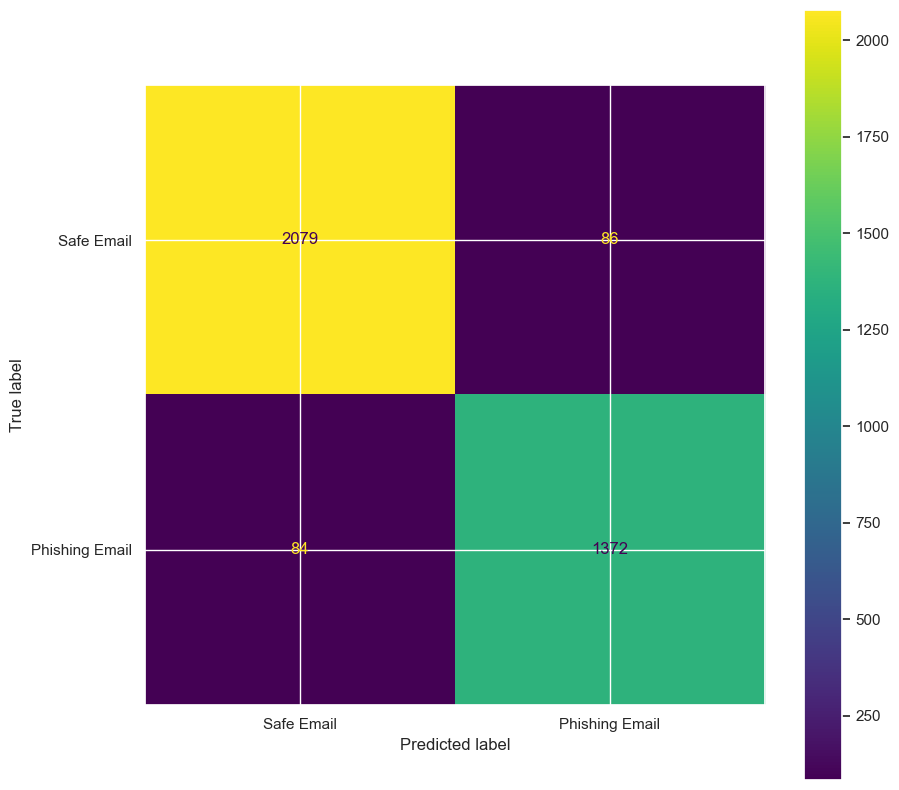

In [159]:
cm = confusion_matrix(y_test, ytst_hat)
cmplot = ConfusionMatrixDisplay(cm, display_labels=["Safe Email", "Phishing Email"])
cmplot.plot()

## Single-layer Neural Network

In [160]:
from tensorflow import keras

input_layer = keras.Input(shape=(len(X_train[0]),))
hidden_layer = keras.layers.Dense(2000, activation="sigmoid")(input_layer)
# hidden_layer = keras.layers.Dense(1000, activation="relu")(hidden_layer)
output_layer = keras.layers.Dense(2, activation="softmax")(hidden_layer)

model = keras.Model(inputs=input_layer, outputs=output_layer, name="email_classifier")
model.summary()

Model: "email_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 2000)                │       2,002,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 2)                   │           4,002 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,006,002 (7.65 MB)

 Trainable params: 2,006,002 (7.65 MB)

 Non-trainable params: 0 (0.00 B)

In [161]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=keras.optimizers.Adam(learning_rate=0.001)
)

history = model.fit(np.array(X_train), np.array(y_train), batch_size=16, epochs=5)
print("Model trained!")

Epoch 1/5
905/905 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - loss: 0.3183
Epoch 2/5
905/905 ━━━━━━━━━━━━━━━━━━━━ 46s 50ms/step - loss: 0.1074
Epoch 3/5
905/905 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - loss: 0.0969
Epoch 4/5
905/905 ━━━━━━━━━━━━━━━━━━━━ 45s 49ms/step - loss: 0.0884
Epoch 5/5
905/905 ━━━━━━━━━━━━━━━━━━━━ 46s 51ms/step - loss: 0.0861
Model trained!


In [162]:
ytst_hat = np.argmax(model.predict(np.array(X_test)), axis=1)
classification_report(y_test, ytst_hat, labels=[0, 1], target_names=["Safe Email", "Phishing Email"], output_dict=True)

114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


{'Safe Email': {'precision': 0.9705603038936372,
  'recall': 0.9441108545034642,
  'f1-score': 0.9571528915944744,
  'support': 2165.0},
 'Phishing Email': {'precision': 0.9201320132013201,
  'recall': 0.9574175824175825,
  'f1-score': 0.9384045775833053,
  'support': 1456.0},
 'accuracy': 0.9494614747307374,
 'macro avg': {'precision': 0.9453461585474787,
  'recall': 0.9507642184605234,
  'f1-score': 0.9477787345888898,
  'support': 3621.0},
 'weighted avg': {'precision': 0.9502831453053981,
  'recall': 0.9494614747307374,
  'f1-score': 0.9496142157589974,
  'support': 3621.0}}

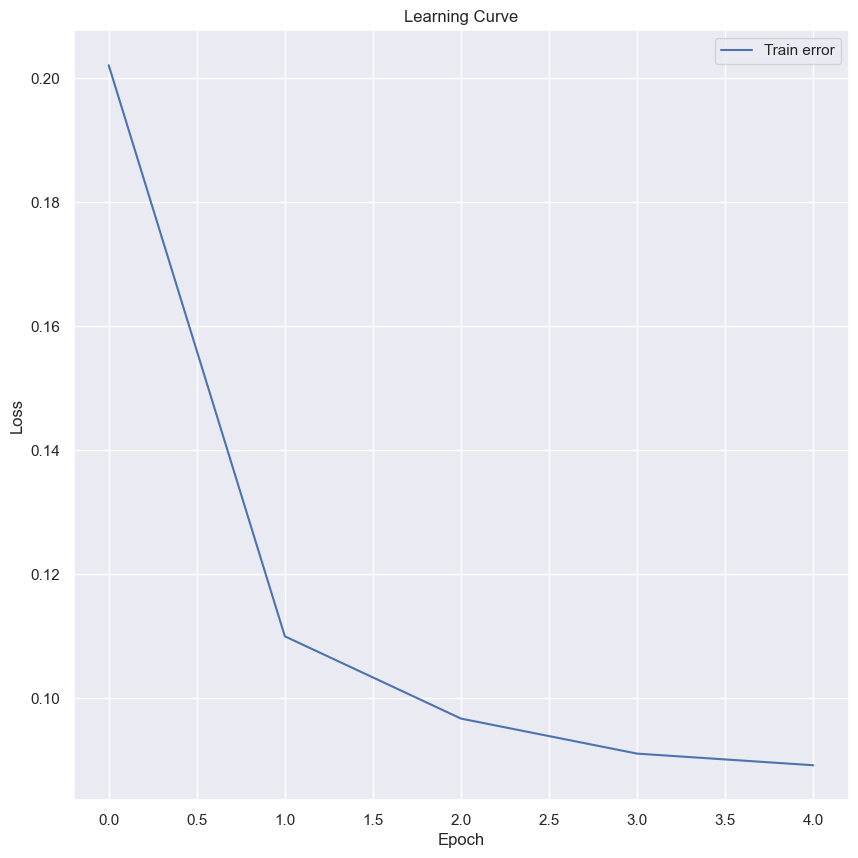

In [164]:
# Source: Neural Networks Homework

plt.plot(history.history["loss"], label='Train error')
plt.title("Learning Curve")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

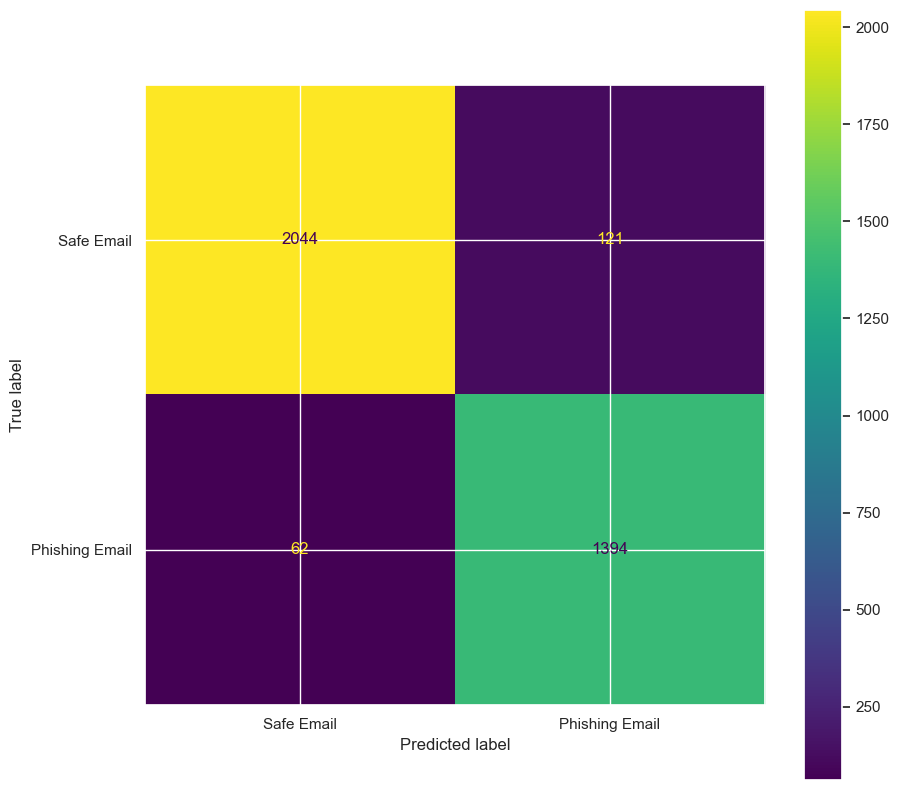

In [163]:
cm = confusion_matrix(y_test, ytst_hat)
cmplot = ConfusionMatrixDisplay(cm, display_labels=["Safe Email", "Phishing Email"])
cmplot.plot()

## Model Evaluation

## Conclusion

## Code references:

https://stackoverflow.com/questions/56447079/how-to-set-x-and-y-axis-title
https://stackoverflow.com/questions/31594549/how-to-change-the-figure-size-of-a-seaborn-axes-or-figure-level-plot
https://stackoverflow.com/questions/43770507/seaborn-bar-plot-ordering
https://stackoverflow.com/questions/10998621/rotate-axis-tick-labels

Tensorflow/Keras documentation

pandas documentation

sklearn documentation

NLTK documentation

Dataset; Subhadeep Chakraborty. (2023). Phishing Email Detection [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/6090437